#Set-up

We install some packages, connect to drive, set the seed and define HPs we'll use for the linear probes throughout the notebook. Feel free to ignore

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install transformers

Mounted at /content/drive


In [2]:
# set seeds
import random
import numpy as np
import torch

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:

CONFIG = {
    # Training hyperparameters
    'learning_rate': 0.02,
    'batch_size': 320 * 60,
    'num_epochs': 10,
    'weight_decay': 0.0,

    # Data splits
    'train_split': 0.8,
    'random_seed': 42,

    # Model parameters
    'num_classes': 2,
    'd_mlp': 512
}

# Load NT model

We load the NT model whose activations we use to train the linear probe. Key variable: size of model

In [4]:
"loading nucleotide transformer"


from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

# prev default 50
num_params = 50 # @param

# Import the tokenizer and the model
tokenizer_nt = AutoTokenizer.from_pretrained(f"InstaDeepAI/nucleotide-transformer-v2-{num_params}m-multi-species", trust_remote_code=True)
model_nt = AutoModelForMaskedLM.from_pretrained(f"InstaDeepAI/nucleotide-transformer-v2-{num_params}m-multi-species", trust_remote_code=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

esm_config.py:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-50m-multi-species:
- esm_config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_esm.py:   0%|          | 0.00/58.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-50m-multi-species:
- modeling_esm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

# Load and preprocess addgene dataset

To get activations from the NT-model, we need to run it on sequences. Here we load and preprocess plasmid sequences from addgene.

In [5]:
import pandas as pd


# Constants
TEST_DATA_PATH = '/content/drive/MyDrive/NOO_paper/datasets/worldwide/blast_geac_ext_169k_val_random.csv'
TRAIN_DATA_PATH = '/content/drive/MyDrive/NOO_paper/datasets/worldwide/blast_geac_ext_169k_train_random.csv'
INFREQUENT_THRESHOLD = 10

def split_test_data(test_data):
    """Split test data into input and target variables."""
    y_test = test_data['nations']
    x_test = test_data[['sequence']]
    return x_test, y_test

def replace_infrequent_labels(labels, threshold=INFREQUENT_THRESHOLD):
    """Identify and replace infrequent labels."""
    label_counts = labels.value_counts()
    infrequent_labels = label_counts[label_counts < threshold].index
    return labels.replace(infrequent_labels, 'infrequent')

def map_labels_to_integers(labels):
    """Map labels to integers."""
    unique_labels = labels.unique()
    return {label: int(i) for i, label in enumerate(unique_labels)}

def without_US(data):
    """Filter out rows where the nation is 'UNITED STATES'."""
    data_wo_US = data[data['nations'] != 'UNITED STATES']
    data_wo_US.reset_index(drop=True, inplace=True)

    data_w_US = data[data['nations'] == 'UNITED STATES']
    data_w_US.reset_index(drop=True, inplace=True)
    return data_wo_US, data_w_US

def US_vs_them(labels):
    """Categorize labels into 'UNITED STATES' and 'NON US'."""
    return labels.apply(lambda x: x if x == 'UNITED STATES' else 'NON US')

def pad_sequence(seq, length, pad_char='N'):
    """Pad sequences to the specified length with the given character."""
    return seq.ljust(length, pad_char)[:length]

# Load data
train_data = pd.read_csv(TRAIN_DATA_PATH)
test_data = pd.read_csv(TEST_DATA_PATH)

print(f'test_data shape: {test_data.shape}')

# Split data
x_train, y_train = train_data[['sequence']], train_data['nations']
x_test, y_test = split_test_data(test_data)

print(f'test_data shape: {y_test.shape}')
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')

# Combine labels from train and test datasets
processed_labels = pd.concat([y_train, y_test], axis=0, ignore_index=True)
label_to_int = map_labels_to_integers(processed_labels)


# map labels to integers
y_train = y_train.map(label_to_int)
y_test = y_test.map(label_to_int)

print(f'y_test shape: {y_test.shape}')


# reset indices before concat
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

df_train = pd.concat([x_train, y_train], axis=1)
df_val = pd.concat([x_test, y_test], axis=1)

print(f'test_data shape: {test_data.shape}')


# Filter out sequences shorter than min_length and clean them
min_length = 0
df_train = df_train[df_train['sequence'].str.len() > min_length]
df_val = df_val[df_val['sequence'].str.len() > min_length]

print(f'test_data shape: {test_data.shape}')


# Ensure indices are reset correctly
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

# Display the split data
print("Train Data Shape:", df_train.shape)
print("Validation Data Shape:", df_val.shape)


test_data shape: (15551, 4)
test_data shape: (15551,)
x_train shape: (93306, 1)
y_train shape: (93306,)
y_test shape: (15551,)
test_data shape: (15551, 4)
test_data shape: (15551, 4)
Train Data Shape: (93306, 2)
Validation Data Shape: (15551, 2)


# Training linear probes

## Set up dataset

In [6]:
## load custom functions from utils.py

import sys
sys.path.append('//content/drive/MyDrive/SAEs_for_Genomics')

import importlib
import pandas as pd
import utils
importlib.reload(utils)

<module 'utils' from '//content/drive/MyDrive/SAEs_for_Genomics/utils.py'>

In [7]:
import pandas as pd
import torch
from tqdm import tqdm
import utils

def load_token_dataframes(base_path, subset_indices=(0,)):
    """Load and combine token dataframes for specified subsets.

    Args:
        base_path (str): Base path to the directory containing token dataframes
        subset_indices (tuple): Indices of subsets to load (e.g., (0,) or (0,1,2))

    Returns:
        dict: Dictionary of dataframes and sequence IDs for each subset
    """
    dataframes = {}
    sequence_ids = {}

    for idx in subset_indices:
        path = f"{base_path}/token_df_1k_ss{idx}.csv"
        try:
            df = pd.read_csv(path)
            dataframes[f's{idx}'] = df
            sequence_ids[f's{idx}'] = sorted(list(set(df['seq_id'])))
        except FileNotFoundError:
            raise FileNotFoundError(f"Token dataframe not found at {path}")

    return {
        'dataframes': dataframes,
        'sequence_ids': sequence_ids
    }

def get_sequences_from_ids(test_data, seq_ids):
    """Extract sequences from test data using sequence IDs.

    Args:
        test_data (pd.DataFrame): Full test dataset
        seq_ids (list): List of sequence IDs to extract

    Returns:
        pd.Series: Extracted sequences
    """
    return test_data.iloc[seq_ids]['sequence']

def get_model_activations(
    model,
    tokenizer,
    sequences,
    layer_num,
    batch_size=128,
    max_length=512,
    device='cuda'
):
    """Get MLP activations for a set of sequences.

    Args:
        model: Neural network model
        tokenizer: Tokenizer for processing sequences
        sequences (list): Input sequences
        layer_num (int): Layer to extract activations from
        batch_size (int): Processing batch size
        max_length (int): Maximum sequence length
        device (str): Device to use for computation

    Returns:
        torch.Tensor: Processed and normalized activations
    """
    # Tokenize sequences
    tokens = tokenizer(
        sequences.tolist(),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )

    # Calculate batching
    total_tokens = tokens['input_ids'].shape[0] * tokens['input_ids'].shape[1]
    num_batches = (total_tokens + batch_size - 1) // batch_size

    # Get activations
    model.eval()
    all_acts = []


    with torch.no_grad():
        pbar = utils.tqdm(total=num_batches, desc="Processing batches")
        for i in range(num_batches):
            pbar.update(1)
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, total_tokens)

            # Prepare batch
            batch_input_ids = tokens['input_ids'][start_idx:end_idx].to(device)
            batch_attention_mask = tokens['attention_mask'][start_idx:end_idx].to(device)

            # Get activations
            mlp_act = utils.get_layer_activations(
                model.to(device),
                batch_input_ids,
                batch_attention_mask,
                layer_N=layer_num
            )
            # reshape from list(tensor(a, b, c)) to tensor(a*b, c)
            mlp_act = mlp_act[0].reshape(-1, model.config.hidden_size)

            # Verify shape
            expected_shape = batch_input_ids.shape[0] * batch_input_ids.shape[1]
            assert mlp_act.shape[0] == expected_shape, (
                f"MLP activation shape {mlp_act.shape[0]} does not match "
                f"expected shape {expected_shape}"
            )

            all_acts.append(mlp_act)

    # Process results
    all_acts = [x.cpu() for x in all_acts]
    activations = torch.cat(all_acts, dim=0).cpu()

    # Normalize
    normalized_acts = (activations - activations.mean(dim=0)) / activations.std(dim=0)

    return normalized_acts

def prepare_probe_inputs(
    test_data,
    model,
    tokenizer,
    token_df_path,
    layer_num=11,
    subset_indices=(0,),
    batch_size=128
):
    """Prepare inputs for linear probe training.

    Args:
        test_data (pd.DataFrame): Test dataset
        model: Neural network model
        tokenizer: Tokenizer
        token_df_path (str): Path to token dataframes
        layer_num (int): Layer to extract activations from
        subset_indices (tuple): Which subsets to use
        batch_size (int): Batch size for processing

    Returns:
        dict: Processed inputs for probe training
    """
    # Load token dataframes
    token_data = load_token_dataframes(token_df_path, subset_indices)

    # Get sequences by first getting seq_ids for all subset indices
    seq_ids = [token_data['sequence_ids'][f's{subset_indices[i]}'] for i in range(len(subset_indices))]
    seq_ids = [item for sublist in seq_ids for item in sublist]
    sequences = get_sequences_from_ids(test_data, seq_ids)

    # Get activations
    activations = get_model_activations(
        model=model,
        tokenizer=tokenizer,
        sequences=sequences,
        layer_num=layer_num,
        batch_size=batch_size
    )

    return {
        'activations': activations,
        'token_data': token_data,
        'sequences': sequences
    }

# Usage example:
layer_N = 11 #@param
probe_inputs = prepare_probe_inputs(
    test_data=test_data, # @param
    model=model_nt,
    tokenizer=tokenizer_nt,
    token_df_path='/content/drive/MyDrive/SAEs_for_Genomics/sae_latent_eval/annotated_seqs',
    layer_num=layer_N,
    subset_indices=(0,1,2)
)

xs = probe_inputs['activations']
token_df_1k_s0 = probe_inputs['token_data']['dataframes']['s0']

Processing batches:   0%|          | 0/11952 [00:00<?, ?it/s]

<Axes: ylabel='token_annotations'>

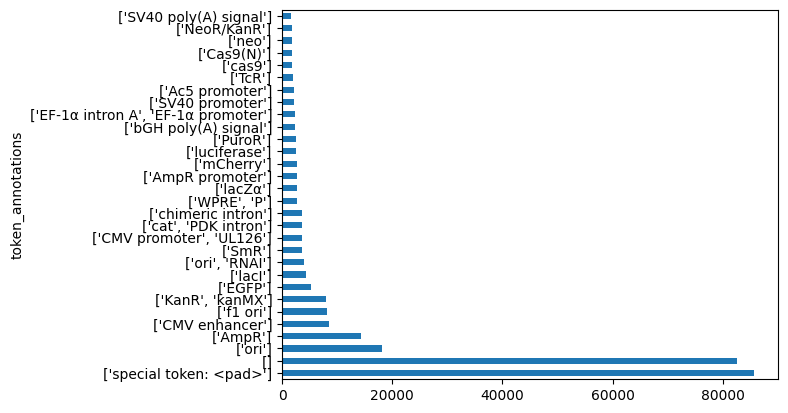

In [8]:
token_df_1k_s0['token_annotations'].value_counts()[:30].plot(kind='barh')

In [9]:
def create_binary_labels(df, annotation_column, annotations, target_value=None):
    """Create binary labels based on whether annotations contain any value from a list.

    Args:
        df (pd.DataFrame): DataFrame containing annotations
        annotation_column (str): Name of column containing annotations
        annotations (list or str): List of target annotations to search for
        target_value (str, optional): Alternative target to search for (e.g., 'TAG')

    Returns:
        pd.Series: Binary labels (0 or 1)
    """
    # Convert single string annotation to list for consistent handling
    if isinstance(annotations, str):
        annotations = [annotations]
    elif not isinstance(annotations, list):
        raise ValueError("Annotations must be a string or list of strings")

    # If using token-based labeling
    if target_value:
        print(f"Using token-based labeling with target value: {target_value}")
        return df['tokens'].apply(lambda x: 1 if target_value in x else 0)

    else:
        print(f"Using annotation-based labeling with annotations: {annotations}")
        # If using annotation-based labeling
        return df[annotation_column].apply(lambda x: 1 if any(ann in x for ann in annotations) else 0)

def compute_class_statistics(labels):
    """Compute basic statistics about class distribution.

    Args:
        labels (pd.Series): Binary labels

    Returns:
        dict: Statistics including positive count, base rate accuracy, class frequency
    """
    positive_count = labels.sum()
    if positive_count == 0:
        return {
            'positive_count': 0,
            'base_rate_accuracy': None,
            'class_frequency': 0
        }

    class_freq = positive_count / len(labels)
    base_rate_acc = max(class_freq, 1 - class_freq)

    return {
        'positive_count': positive_count,
        'base_rate_accuracy': base_rate_acc,
        'class_frequency': class_freq
    }

def prepare_tensors(features, labels, device='cuda'):
    """Prepare feature and label tensors for PyTorch training.

    Args:
        features (torch.Tensor): Input features
        labels (pd.Series): Binary labels
        device (str): Target device for tensors

    Returns:
        tuple: (feature tensor, label tensor)
    """
    x_tensor = features.clone().detach().to(dtype=torch.float32)
    y_tensor = torch.tensor(labels.values, dtype=torch.float32)

    return x_tensor, y_tensor

def process_annotation(df, xs, target_value =None, annotation='CMV enhancer', annotation_column='token_annotations'):
    """Process a single annotation and prepare data for training.

    Args:
        df (pd.DataFrame): Input DataFrame with annotations
        xs (torch.Tensor): Feature tensor
        annotation (str): Target annotation
        annotation_column (str): Column containing annotations

    Returns:
        dict: Processed data and statistics

    Raises:
        ValueError: If no positive examples found for annotation
    """
    # Create labels
    labels = create_binary_labels(df, annotation_column, annotation, target_value=target_value)

    # Compute statistics
    stats = compute_class_statistics(labels)
    if stats['positive_count'] == 0:
        raise ValueError(f"No positive examples found for annotation: {annotation}")

    # Prepare tensors
    x_tensor, y_tensor = prepare_tensors(xs, labels)

    return {
        'features': x_tensor,
        'labels': y_tensor,
        'statistics': stats
    }

"""
# Example usage:
try:
    annotation = ['RRE', 'env', 'cPPT/CTS', 'gag-pol', 'HIV-1 gag']
    result = process_annotation(
        df=token_df_1k_s0,
        xs=xs,
        annotation=annotation
    )
    x_tensor = result['features']
    y_tensor = result['labels']

    print(f"Baserate accuracy for {annotation}: {result['statistics']['base_rate_accuracy']:.4f}")
except ValueError as e:
    print(f"Error: {e}")

"""

'\n# Example usage:\ntry:\n    annotation = [\'RRE\', \'env\', \'cPPT/CTS\', \'gag-pol\', \'HIV-1 gag\']\n    result = process_annotation(\n        df=token_df_1k_s0,\n        xs=xs,\n        annotation=annotation\n    )\n    x_tensor = result[\'features\']\n    y_tensor = result[\'labels\']\n\n    print(f"Baserate accuracy for {annotation}: {result[\'statistics\'][\'base_rate_accuracy\']:.4f}")\nexcept ValueError as e:\n    print(f"Error: {e}")\n\n'

## Actual Training

Choose which annotation

In [18]:
from torch.utils.data import TensorDataset, DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn as nn
import torch.optim as optim
import copy


#Training Classes
class ProbeTrainer:
    def __init__(self, model, loss_weight = None, config=CONFIG):
        self.model = model
        self.config = config
        self.criterion = nn.BCEWithLogitsLoss() if loss_weight is None else nn.BCEWithLogitsLoss(pos_weight=loss_weight) ## acounting for class imb
        self.optimizer = optim.Adam(
            model.parameters(),
            lr=config['learning_rate'],
            weight_decay=config['weight_decay']
        )
        # Early stopping parameters
        self.patience = 5  # Number of epochs to wait for improvement
        self.min_delta = 1e-4  # Minimum change in validation F1 to qualify as an improvement


    def create_data_loaders(self, x_tensor, y_tensor):
        """Create train and validation data loaders with stratified split"""
        dataset = TensorDataset(x_tensor, y_tensor)


        sss = StratifiedShuffleSplit(
            n_splits=1,
            test_size=1-self.config['train_split'],
            random_state=self.config['random_seed']
        )
        train_idx, val_idx = next(sss.split(x_tensor, y_tensor))

        train_dataset = Subset(dataset, train_idx)
        val_dataset = Subset(dataset, val_idx)

        train_loader = DataLoader(
            train_dataset,
            batch_size=self.config['batch_size'],
            shuffle=True
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=self.config['batch_size'],
            shuffle=False
        )

        return train_loader, val_loader

    def train_epoch(self, train_loader):
        """Train for one epoch"""
        self.model.train()
        model.cuda() if torch.cuda.is_available() else model.cpu()
        train_loss = 0.0

        for inputs, targets in train_loader:
            self.optimizer.zero_grad()
            outputs = self.model(inputs.cuda())
            loss = self.criterion(outputs.squeeze().cpu(), targets)
            loss.backward()
            self.optimizer.step()
            train_loss += loss.item()

        return train_loss / len(train_loader)

    def evaluate(self, val_loader):
        """Evaluate model on validation set"""
        self.model.eval()
        val_loss = 0.0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = self.model(inputs.cuda())
                loss = self.criterion(outputs.squeeze().cpu(), targets)
                val_loss += loss.item()
                preds = torch.round(torch.sigmoid(outputs))
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        metrics = {
            'loss': val_loss / len(val_loader),
            'accuracy': accuracy_score(all_targets, all_preds),
            'precision': precision_score(all_targets, all_preds),
            'recall': recall_score(all_targets, all_preds),
            'f1': f1_score(all_targets, all_preds)
        }

        return metrics

    def train(self, x_tensor, y_tensor):
        """Full training loop with validation and early stopping"""
        train_loader, val_loader = self.create_data_loaders(x_tensor, y_tensor)
        best_f1 = 0.0
        best_metrics = None
        best_model_state = None
        patience_counter = 0

        for epoch in range(self.config['num_epochs']):
            train_loss = self.train_epoch(train_loader)
            metrics = self.evaluate(val_loader)

            # Check if current F1 score is better than best F1
            if metrics['f1'] > best_f1 + self.min_delta:
                best_f1 = metrics['f1']
                best_metrics = metrics
                best_model_state = copy.deepcopy(self.model.state_dict())
                patience_counter = 0
            else:
                patience_counter += 1

            print(f"Epoch {epoch+1}/{self.config['num_epochs']}")
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Metrics: {metrics}")
            print(f"Best F1: {best_f1:.4f}")
            print(f"Patience Counter: {patience_counter}/{self.patience}")

            # Early stopping check
            if patience_counter >= self.patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

        # Restore best model
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)

        return best_metrics

# Usage in main notebook
def create_probe_model(d_mlp, n_classes):
    return nn.Linear(d_mlp, n_classes - 1)

def create_mlp_model(d_mlp, n_classes):
    return nn.Sequential(
        nn.Linear(d_mlp, d_mlp),
        nn.ReLU(),
        nn.Linear(d_mlp, n_classes - 1))
# For each annotation experiment:
annotation = '' #['FP', 'Cherry', 'Tomato','Apple','Clover'] # @param
target_value = 'CGAGGG' if annotation == '' else None
print("Processing annotation:", annotation)
token_dfs = pd.concat([probe_inputs['token_data']['dataframes']['s0'], probe_inputs['token_data']['dataframes']['s1'], probe_inputs['token_data']['dataframes']['s2']], ignore_index=True)

result = process_annotation(
    df=token_dfs,
    xs=xs,
    annotation=annotation,
    target_value = target_value
)
x_tensor = result['features']
y_tensor = result['labels']


address_imbalance = True
if address_imbalance:
    # Calculate class weights based on inverse frequency
    n_samples = len(y_tensor)
    n_positive = y_tensor.sum()
    pos_weight = (n_samples - n_positive) / n_positive

torch.cuda.empty_cache()

model = create_probe_model(CONFIG['d_mlp'], CONFIG['num_classes'])
trainer = ProbeTrainer(model, loss_weight = torch.tensor([pos_weight]))
results = trainer.train(x_tensor, y_tensor)


Processing annotation: 
Using token-based labeling with target value: CGAGGG
Epoch 1/10
Train Loss: 0.5124
Val Metrics: {'loss': 0.30267123505473137, 'accuracy': 0.9818643536009831, 'precision': 0.020995059985885675, 'recall': 1.0, 'f1': 0.04112666321064455}
Best F1: 0.0411
Patience Counter: 0/5
Epoch 2/10
Train Loss: 0.2221
Val Metrics: {'loss': 0.16359562054276466, 'accuracy': 0.9961532427803851, 'precision': 0.09182098765432099, 'recall': 1.0, 'f1': 0.16819787985865725}
Best F1: 0.1682
Patience Counter: 0/5
Epoch 3/10
Train Loss: 0.1264
Val Metrics: {'loss': 0.0986427552998066, 'accuracy': 0.9993398088714, 'precision': 0.3707165109034268, 'recall': 1.0, 'f1': 0.5409090909090909}
Best F1: 0.5409
Patience Counter: 0/5
Epoch 4/10
Train Loss: 0.0825
Val Metrics: {'loss': 0.06883071549236774, 'accuracy': 0.9992090779548456, 'precision': 0.3296398891966759, 'recall': 1.0, 'f1': 0.49583333333333335}
Best F1: 0.5409
Patience Counter: 1/5
Epoch 5/10
Train Loss: 0.0595
Val Metrics: {'loss': 0

KeyboardInterrupt: 

# Loop over annotations

In [ ]:
import pandas as pd
from datetime import datetime

d_mlp = model_nt.config.hidden_size
results_dict = {}

annotations = ['CMV enhancer', 'SV40 promoter', 'AmpR promoter',  'EGFP', 'luciferase', 'mCherry', 'ori', 'f1 ori','AmpR', 'KanR']
seeds = [42*i for i in range(5)]
address_imbalance = True # weighting BCE loss
CONFIG['num_epochs'] = 50 # just for test purposes
CONFIG['batch_size'] = int(4e3)
all_tokens_dfs = pd.concat([probe_inputs['token_data']['dataframes']['s0'], probe_inputs['token_data']['dataframes']['s1'], probe_inputs['token_data']['dataframes']['s2']], ignore_index=True)

for annotation in annotations:
    results_dict[annotation] = {}  # Create nested dict for each annotation

    for seed in seeds:
        CONFIG['random_seed'] = seed
        print(f"Training with seed {seed}")
        # Set random seeds for reproducibility
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)

        try:
            target_value = None
            result = process_annotation(
                df=all_tokens_dfs,
                xs=xs,
                annotation=annotation,
                target_value=target_value
            )
            x_tensor = result['features']
            y_tensor = result['labels']

            if address_imbalance:
                n_samples = len(y_tensor)
                n_positive = y_tensor.sum()
                pos_weight = (n_samples - n_positive) / n_positive

            model = create_probe_model(d_mlp, CONFIG['num_classes'])
            trainer = ProbeTrainer(model, loss_weight=torch.tensor([pos_weight]), config=CONFIG)
            results = trainer.train(x_tensor, y_tensor)

            # Save results for this seed
            results_dict[annotation][f'seed_{seed}'] = results

            # Create DataFrame with MultiIndex
            results_list = []
            for ann in results_dict:
                for seed_key, seed_results in results_dict[ann].items():
                    row = {
                        'annotation': ann,
                        'seed': int(seed_key.split('_')[1]),  # Extract seed number
                        **seed_results  # Unpack all metrics
                    }
                    results_list.append(row)

            results_df = pd.DataFrame(results_list)



        except ValueError as e:
            print(f"Error processing annotation {annotation} with seed {seed}: {e}")

# After all runs are complete, calculate summary statistics

summary_df = results_df.groupby('annotation').agg({
    'f1': ['mean', 'std'],
    'precision': ['mean', 'std'],
    'accuracy': ['mean', 'std'],
    'recall': ['mean', 'std']
}).round(4)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
summary_filename = f'/content/drive/MyDrive/SAEs_for_Genomics/probe_results_NT50.L{layer_N+1}mlp_summary_{timestamp}_val012.csv'
summary_df.to_csv(summary_filename)

Training with seed 0
Using annotation-based labeling with annotations: ['CMV enhancer']
Epoch 1/50
Train Loss: 0.3205
Val Metrics: {'loss': 0.1884754044669015, 'accuracy': 0.9626076895925118, 'precision': 0.3778569471087969, 'recall': 0.9871134020618557, 'f1': 0.5465139323794046}
Best F1: 0.5465
Patience Counter: 0/5
Epoch 2/50
Train Loss: 0.1584
Val Metrics: {'loss': 0.14166118998032112, 'accuracy': 0.9747623965591623, 'precision': 0.4745060107779467, 'recall': 0.9833906071019473, 'f1': 0.6401342156771367}
Best F1: 0.6401
Patience Counter: 0/5
Epoch 3/50
Train Loss: 0.1433
Val Metrics: {'loss': 0.1287662008559549, 'accuracy': 0.975948779626894, 'precision': 0.48673693145646174, 'recall': 0.9852520045819015, 'f1': 0.6515789972065716}
Best F1: 0.6516
Patience Counter: 0/5
Epoch 4/50
Train Loss: 0.1394
Val Metrics: {'loss': 0.14403949726324577, 'accuracy': 0.9789196397055939, 'precision': 0.5202856708706883, 'recall': 0.9805269186712485, 'f1': 0.6798371885237764}
Best F1: 0.6798
Patience

# Control 1: random transformer weights

Suppose we find that an annotation A can be predicred from the gLMs activations with a probe. Is this the result of the gLMs pretraining or is this merely a product of the data and the architecture? To test this, we try training linear probes to predict the annoation from a randomly initialised version of the same gLM.

In [ ]:
from transformers import AutoConfig, AutoModelForMaskedLM


# Get random init transformer
config = AutoConfig.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-50m-multi-species")
model_nt = AutoModelForMaskedLM.from_config(config)

# verfiy its randomly init
model_nt.init_weights()

The repository for InstaDeepAI/nucleotide-transformer-v2-50m-multi-species contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/InstaDeepAI/nucleotide-transformer-v2-50m-multi-species.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [ ]:
import pandas as pd
from datetime import datetime

d_mlp = model_nt.config.hidden_size
results_randominputs_dict = {}

annotations = ['SV40 promoter', 'chicken ', 'SmR', 'CMV enhancer', 'PuroR', 'ori', 'f1 ori', 'C9orf85', 'RRE', 'HIV']

seeds = [42*i for i in range(5)]
address_imbalance = True # weighting BCE loss
CONFIG['num_epochs'] = 50 #
CONFIG['batch_size'] = int(4e3)


for annotation in annotations:

    print("Processing annotation:", annotation)

    probe_inputs = prepare_probe_inputs(
        test_data=test_data,
        model=model_nt,
        tokenizer=tokenizer_nt,
        token_df_path='/content/drive/MyDrive/SAEs_for_Genomics/Annotated_seqs',
        layer_num=11,
        subset_indices=(0,1,2) #@param
    )

    xs_random = probe_inputs['activations']
    token_dfs = pd.concat([probe_inputs['token_data']['dataframes']['s0'], probe_inputs['token_data']['dataframes']['s1'], probe_inputs['token_data']['dataframes']['s2']], ignore_index=True)


    result = process_annotation(
        df=token_dfs,
        xs=xs_random,
        annotation=annotation
    )

    x_tensor_random = result['features']
    y_tensor = result['labels']

    address_imbalance = True
    if address_imbalance:
        # Calculate class weights based on inverse frequency
        n_samples = len(y_tensor)
        n_positive = y_tensor.sum()
        pos_weight = (n_samples - n_positive) / n_positive

    results_randominputs_dict[annotation] = {}  # Create nested dict for each annotation

    for seed in seeds:
        try:
            CONFIG['random_seed'] = seed
            print(f"Training with seed {seed}")
            # Set random seeds for reproducibility
            np.random.seed(seed)
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed(seed)

            # reinit model weights
            model_nt.init_weights()

            model = create_probe_model(CONFIG['d_mlp'], CONFIG['num_classes'])
            trainer = ProbeTrainer(model, loss_weight = torch.tensor([pos_weight]))
            results = trainer.train(x_tensor_random, y_tensor)


            # Save results for this seed
            results_randominputs_dict[annotation][f'seed_{seed}'] = results



        except ValueError as e:
            print(f"Error processing annotation {annotation} with seed {seed}: {e}")
            continue

    # Create DataFrame with MultiIndex
    results_list = []
    for ann in results_randominputs_dict:
        for seed_key, seed_results in results_randominputs_dict[ann].items():
            row = {
                'annotation': ann,
                'seed': int(seed_key.split('_')[1]),  # Extract seed number
                **seed_results  # Unpack all metrics
            }
            results_list.append(row)

    results_randominputs_df = pd.DataFrame(results_list)



# After all runs are complete, calculate summary statistics

summary_df =  results_randominputs_df.groupby('annotation').agg({
    'f1': ['mean', 'std'],
    'precision': ['mean', 'std'],
    'accuracy': ['mean', 'std'],
    'recall': ['mean', 'std']
}).round(4)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
summary_filename = f'/content/drive/MyDrive/SAEs_for_Genomics/probe_results_NT50.RANDOMinit.L12mlp_summary_{timestamp}_val012.csv'
summary_df.to_csv(summary_filename)

Processing annotation: SV40 promoter


Processing batches:   0%|          | 0/11952 [00:00<?, ?it/s]

# Control 2: linear probing on raw tokens

Here we train a linear probe on one-hot encoded vectors of tokens. This tests whether the model representation contains additional information relevant to predicting the functional annotation, exceeding an arbitrary but consistent representation.

In [ ]:
import pandas as pd
import torch
from tqdm import tqdm
import utils

def get_token_id_embeddings(
    tokenizer,
    sequences,
    max_length=512,
    device='cuda'
):
    """Get one-hot encoded token IDs for a set of sequences.

    Args:
        tokenizer: Tokenizer for processing sequences
        sequences (list): Input sequences
        max_length (int): Maximum sequence length
        device (str): Device to use for computation

    Returns:
        torch.Tensor: One-hot encoded token IDs
    """
    # Tokenize sequences
    tokens = tokenizer(
        sequences.tolist(),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )

    # Get token IDs
    token_ids = tokens['input_ids']

    # Create one-hot encoding
    vocab_size = tokenizer.vocab_size
    one_hot = torch.zeros((token_ids.numel(), vocab_size))
    one_hot.scatter_(1, token_ids.reshape(-1, 1), 1)

    return one_hot

def prepare_token_probe_inputs(
    test_data,
    tokenizer,
    token_df_path,
    subset_indices=(0,),
):
    """Prepare token ID inputs for linear probe training.

    Args:
        test_data (pd.DataFrame): Test dataset
        tokenizer: Tokenizer
        token_df_path (str): Path to token dataframes
        subset_indices (tuple): Which subsets to use

    Returns:
        dict: Processed inputs for probe training
    """
    # Load token dataframes
    token_data = load_token_dataframes(token_df_path, subset_indices)

    # Get sequences
    seq_ids = token_data['sequence_ids'][f's{subset_indices[0]}']  # Using first subset
    sequences = get_sequences_from_ids(test_data, seq_ids)

    # Get token ID embeddings
    token_embeddings = get_token_id_embeddings(
        tokenizer=tokenizer,
        sequences=sequences,
    )

    return {
        'token_embeddings': token_embeddings,
        'token_data': token_data,
        'sequences': sequences
    }

# Usage:
probe_inputs = prepare_token_probe_inputs(
    test_data=test_data,
    tokenizer=tokenizer_nt,
    token_df_path='/content/drive/MyDrive/SAEs_for_Genomics/Annotated_seqs',
    subset_indices=(0,)
)

xs = probe_inputs['token_embeddings']
token_df_1k_s0 = probe_inputs['token_data']['dataframes']['s0']

In [ ]:
import pandas as pd
from datetime import datetime


results_onehot_dict = {}

annotations = ['SV40 promoter', 'chicken β-actin promoter', 'SmR', 'CMV promoter', 'CMV enhancer', 'PuroR', 'ori', 'f1 ori', 'C9orf85']

seeds = [42*i for i in range(5)]
address_imbalance = True # weighting BCE loss
CONFIG['num_epochs'] = 50 #
CONFIG['batch_size'] = int(4e3)


for annotation in annotations:


    print("Processing annotation:", annotation)
    target_value = None

    try:

        probe_inputs = prepare_token_probe_inputs(
            test_data=test_data,
            tokenizer=tokenizer_nt,
            token_df_path='/content/drive/MyDrive/SAEs_for_Genomics/Annotated_seqs',
            subset_indices=(0,)
        )

        xs = probe_inputs['token_embeddings']
        token_df_1k_s0 = probe_inputs['token_data']['dataframes']['s0']

        # check xs are one-hot-encoded
        assert torch.all(torch.eq(xs.sum(dim=1), torch.ones(xs.shape[0])))
        assert xs.shape[1] == tokenizer_nt.vocab_size
        assert xs.shape[0] == len(token_df_1k_s0)

        result = process_annotation(
            df=token_df_1k_s0,
            xs=xs,
            annotation=annotation,
            target_value = target_value
        )

        x_tensor = result['features']
        y_tensor = result['labels']


        address_imbalance = True
        if address_imbalance:
            # Calculate class weights based on inverse frequency
            n_samples = len(y_tensor)
            n_positive = y_tensor.sum()
            pos_weight = (n_samples - n_positive) / n_positive

        torch.cuda.empty_cache()
        results_onehot_dict[annotation] = {}  # Create nested dict for each annotation

    except ValueError as e:
        print(f"Error processing annotation {annotation}: {e}")
        continue

    for seed in seeds:

          model = create_probe_model(tokenizer_nt.vocab_size, CONFIG['num_classes'])
          trainer = ProbeTrainer(model, loss_weight = torch.tensor([pos_weight]))

          try:
              results = trainer.train(x_tensor, y_tensor)
              results_onehot_dict[annotation][f'seed_{seed}'] = results

          except ValueError as e:
              print(f"Error processing annotation {annotation} with seed {seed}: {e}")
              continue


    # Create DataFrame with MultiIndex
    results_list = []
    for ann in results_onehot_dict:
        for seed_key, seed_results in results_onehot_dict[ann].items():
            row = {
                'annotation': ann,
                'seed': int(seed_key.split('_')[1]),  # Extract seed number
                **seed_results  # Unpack all metrics
            }
            results_list.append(row)

    results_onehot_df = pd.DataFrame(results_list)



# After all runs are complete, calculate summary statistics

summary_df = results_onehot_df.groupby('annotation').agg({
    'f1': ['mean', 'std'],
    'precision': ['mean', 'std'],
    'accuracy': ['mean', 'std'],
    'recall': ['mean', 'std']
}).round(4)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
summary_filename = f'/content/drive/MyDrive/SAEs_for_Genomics/probe_results_control.onehottokens_summary_{timestamp}.csv'
summary_df.to_csv(summary_filename)


Processing annotation: CMV enhancer
Using annotation-based labeling with annotations: ['CMV enhancer']
Epoch 1/50
Train Loss: 0.9663
Val Metrics: {'loss': 0.6799247012688563, 'accuracy': 0.9281804140843418, 'precision': 0.22994595740171664, 'recall': 0.9644444444444444, 'f1': 0.3713527851458886}
Best F1: 0.3714
Patience Counter: 0/5
Epoch 2/50
Train Loss: 0.5470
Val Metrics: {'loss': 0.47418186412407803, 'accuracy': 0.9290797474046414, 'precision': 0.23232431276072307, 'recall': 0.9653333333333334, 'f1': 0.37451504440037936}
Best F1: 0.3745
Patience Counter: 0/5
Epoch 3/50
Train Loss: 0.4073
Val Metrics: {'loss': 0.4004965332838205, 'accuracy': 0.9289233416098066, 'precision': 0.23187012709601623, 'recall': 0.9648888888888889, 'f1': 0.3738913286833721}
Best F1: 0.3745
Patience Counter: 1/5
Epoch 4/50
Train Loss: 0.3493
Val Metrics: {'loss': 0.37019889056682587, 'accuracy': 0.9291677256642359, 'precision': 0.23237625883865437, 'recall': 0.964, 'f1': 0.374482044198895}
Best F1: 0.3745
Pa

# Control 3: random token labeling

**Conclusion: In my dataset, each token is on average associated with 120 different labels, depending on the context. This makes the control task (same token same label) much easier. I think it makes it so much easier that it no longer serves as a good control. **

Inspired by Hewitt & Lang (2019) we create binary random labels as a control-task. The control task is supposed to have the following properties:


1.   Identical tokens always get the same label
2.   Each unique token gets a random label assignment
3.   The class-distribution is identical between the original and the control task


The motivation is this:



*   Due to structure (deterministic mapping), the probe can still learn the task through memorization
*   Due to randomness, no representation could have learned this task in advance
*   By keeping class distributions identical, differences in performance can't be attributed to class imbalance





## Utils

Here we define the functions that accomplish the re-labeling scheme with the properties listed above

In [ ]:
import numpy as np
import torch
import pandas as pd
from typing import List, Dict
from tqdm.auto import tqdm

def verify_label_consistency(
    tokens: pd.Series,
    labels: torch.Tensor
) -> None:
    """Verifies that identical tokens have identical labels efficiently.

    Args:
        tokens: Series of tokens
        labels: Tensor of labels

    Raises:
        AssertionError: If identical tokens have different labels
    """

    # Convert to pandas Series for efficient groupby
    labels_series = pd.Series(labels.numpy())

    # Group by tokens and check if any group has more than one unique label
    inconsistent_tokens = tokens.groupby(tokens).agg(
        lambda x: labels_series.iloc[x.index].nunique()
    )

    # Check if any tokens have more than one unique label
    if (inconsistent_tokens > 1).any():
        problematic_tokens = inconsistent_tokens[inconsistent_tokens > 1].index
        raise AssertionError(f"Tokens {problematic_tokens.tolist()} have inconsistent labels!")

    else:
        print("All tokens have consistent labels!")

def create_control_labels(
    y_tensor: torch.Tensor,
    tokens: pd.Series,
    vocab: List[str]
) -> torch.Tensor:
    """Creates control labels maintaining class distribution and token consistency.

    Args:
        y_tensor: Original binary labels tensor
        tokens: Series of tokens
        vocab: Complete vocabulary

    Returns:
        torch.Tensor: Control labels with same properties as original
    """
    # Calculate target number of ones
    n_total = len(tokens)
    n_ones_target = int(torch.sum(y_tensor))

    # Create initial random mapping
    mapping = {}
    running_ones = 0

    # Sort tokens by frequency for efficient assignment
    token_freqs = tokens.value_counts()
    token_list = sorted([(t, token_freqs.get(t, 0)) for t in vocab],
                       key=lambda x: x[1], reverse=True)

    # First pass: assign labels to maintain class distribution
    for token, freq in token_list:
        if running_ones + freq <= n_ones_target:
            mapping[token] = 1
            running_ones += freq
        else:
            mapping[token] = 0

    print(f"Target ones: {n_ones_target}, Got ones: {running_ones}")

    # Randomly shuffle assignments while maintaining frequencies
    ones_tokens = [t for t, _ in token_list if mapping[t] == 1]
    zeros_tokens = [t for t, _ in token_list if mapping[t] == 0]
    np.random.shuffle(ones_tokens)
    np.random.shuffle(zeros_tokens)

    # Recreate mapping
    mapping = {}
    mapping.update({t: 1 for t in ones_tokens})
    mapping.update({t: 0 for t in zeros_tokens})

    # Create final labels using mapping
    y_tensor_random = torch.tensor([mapping[token] for token in tokens], dtype=torch.float32)

    # Verify properties
    print("Verifying label consistency...")
    verify_label_consistency(tokens, y_tensor_random)
    assert abs(torch.mean(y_tensor) - torch.mean(y_tensor_random)) < 1e-6, \
        f"Different class frequencies: {torch.mean(y_tensor):.4f} vs {torch.mean(y_tensor_random):.4f}"

    print(f"Label consistency verified! Class frequencies are preserved: {torch.mean(y_tensor_random):.4f}, {torch.mean(y_tensor):.4f}")
    return y_tensor_random

def shuffle_labels_randomly(y_tensor: torch.Tensor) -> torch.Tensor:
    """Shuffles labels randomly.

    Args:
        y_tensor: Tensor of labels

    Returns:
        torch.Tensor: Shuffled labels
        """
    shuffled_indices = torch.randperm(len(y_tensor))
    y_tensor_shuffled = y_tensor[shuffled_indices]
    return y_tensor_shuffled

# Main loop
annotations = ['CMV enhancer']
target_value = 'TATA' if annotations[0] == '' else None


for annotation in annotations:

    result = process_annotation(
            df=token_df_1k_s0,
            xs=xs,
            annotation=annotation,
            target_value = target_value
        )
    x_tensor = result['features']
    y_tensor = result['labels']

    print("Processing annotation:", annotation)
    # Get random labels
    y_tensor_random = shuffle_labels_randomly(y_tensor)
    assert torch.mean(y_tensor) == torch.mean(y_tensor_random), "Class frequencies are not the same"

Processing annotation: CMV enhancer
Using annotation-based labeling with annotations: ['CMV enhancer']
Processing annotation: CMV enhancer


In [ ]:
ones = torch.sum(y_tensor)
ones_random = torch.sum(y_tensor_random)

assert ones == ones_random, "Number of ones is not the same"
assert torch.mean(y_tensor) == torch.mean(y_tensor_random), "Class frequencies are not the same"

## Training on control-task

In [ ]:
import pandas as pd
from datetime import datetime

d_mlp = model_nt.config.hidden_size
results_randomlabel_dict = {}

annotations = ['CMV enhancer']
seeds = [42*i for i in range(5)]
address_imbalance = True # weighting BCE loss
CONFIG['num_epochs'] = 50 #
CONFIG['batch_size'] = int(4e3)


for annotation in annotations:

    for seed in seeds:
          print("Processing annotation:", annotation)
          result = process_annotation(
              df=token_df_1k_s0,
              xs=xs,
              annotation=annotation,
              target_value = target_value
          )
          x_tensor = result['features']
          y_tensor = result['labels']

          print("Processing annotation:", annotation)

          # Get random labels

          y_tensor_random = shuffle_labels_randomly(y_tensor)
          address_imbalance = True
          if address_imbalance:
              # Calculate class weights based on inverse frequency
              n_samples = len(y_tensor_random)
              n_positive = y_tensor_random.sum()
              pos_weight = (n_samples - n_positive) / n_positive


          results_randomlabel_dict[annotation] = {}  # Create nested dict for each annotation

          try:
              CONFIG['random_seed'] = seed
              print(f"Training with seed {seed}")
              # Set random seeds for reproducibility
              np.random.seed(seed)
              torch.manual_seed(seed)
              if torch.cuda.is_available():
                  torch.cuda.manual_seed(seed)

              model = create_probe_model(CONFIG['d_mlp'], CONFIG['num_classes'])
              trainer = ProbeTrainer(model, loss_weight = torch.tensor([pos_weight]))
              results = trainer.train(x_tensor, y_tensor_random)


              # Save results for this seed
              results_randomlabel_dict[annotation][f'seed_{seed}'] = results



          except ValueError as e:
              print(f"Error processing annotation {annotation} with seed {seed}: {e}")
              continue

    # Create DataFrame with MultiIndex
    results_list = []
    for ann in results_randomlabel_dict:
        for seed_key, seed_results in results_randomlabel_dict[ann].items():
            row = {
                'annotation': ann,
                'seed': int(seed_key.split('_')[1]),  # Extract seed number
                **seed_results  # Unpack all metrics
            }
            results_list.append(row)

    results_randomlabel_df = pd.DataFrame(results_list)



# After all runs are complete, calculate summary statistics

summary_df = results_randomlabel_df.groupby('annotation').agg({
    'f1': ['mean', 'std'],
    'precision': ['mean', 'std'],
    'accuracy': ['mean', 'std'],
    'recall': ['mean', 'std']
}).round(4)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
summary_filename = f'/content/drive/MyDrive/SAEs_for_Genomics/probe_results_RANDOMlabels_NT50.L5mlp_summary_{timestamp}.csv'
summary_df.to_csv(summary_filename)


Processing annotation: CMV enhancer
Using annotation-based labeling with annotations: ['CMV enhancer']
Processing annotation: CMV enhancer
Training with seed 0
Epoch 1/50
Train Loss: 1.5145
Val Metrics: {'loss': 1.5374728670487037, 'accuracy': 0.4502922833290973, 'precision': 0.02160504767643827, 'recall': 0.5417777777777778, 'f1': 0.041553040632669756}
Best F1: 0.0416
Patience Counter: 0/5
Epoch 2/50
Train Loss: 1.4923
Val Metrics: {'loss': 1.4989721179008484, 'accuracy': 0.5190130794345931, 'precision': 0.022164780591060817, 'recall': 0.484, 'f1': 0.042388385037561795}
Best F1: 0.0424
Patience Counter: 0/5
Epoch 3/50
Train Loss: 1.4921
Val Metrics: {'loss': 1.5073719804103558, 'accuracy': 0.43326360241646955, 'precision': 0.02178017300562955, 'recall': 0.564, 'f1': 0.0419407079353538}
Best F1: 0.0424
Patience Counter: 1/5
Epoch 4/50
Train Loss: 1.4747
Val Metrics: {'loss': 1.48194204385464, 'accuracy': 0.4891102465346341, 'precision': 0.021983063483264197, 'recall': 0.511111111111111

KeyboardInterrupt: 

# Results

Let's compare the F1 score for annotations across the task and the two controlsi

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the three summary files
# Adjust filenames to match your saved files
onehot_df = pd.read_csv('/content/drive/MyDrive/SAEs_for_Genomics/Probe Results L12 NT50/probe_results_NT50.L11mlp_control.onehottokens_summary_20250223_122731.csv', index_col=0)
print(onehot_df.head())
random_init_df = pd.read_csv('/content/drive/MyDrive/SAEs_for_Genomics/Probe Results L12 NT50/probe_results_NT50.RANDOMinit.L12mlp_summary_20250223_135819.csv', index_col=0)
print(random_init_df.head())
original_df = pd.read_csv('/content/drive/MyDrive/SAEs_for_Genomics/Probe Results L12 NT50/probe_results_NT50.L12mlp_summary_20250221_202348.csv', index_col=0)
print(original_df.head())


                  f1    f1.1 precision precision.1 accuracy accuracy.1  \
NaN             mean     std      mean         std     mean        std   
annotation       NaN     NaN       NaN         NaN      NaN        NaN   
C9orf85       0.0018  0.0009    0.0009      0.0004   0.9858     0.0039   
CMV enhancer  0.3883  0.0023    0.2437       0.002   0.9338     0.0008   
CMV promoter  0.2753  0.0052    0.1613      0.0034   0.9402     0.0013   

              recall recall.1  
NaN             mean      std  
annotation       NaN      NaN  
C9orf85         0.06   0.0224  
CMV enhancer  0.9551   0.0028  
CMV promoter  0.9407   0.0058  
                  f1    f1.1 precision precision.1 accuracy accuracy.1  \
NaN             mean     std      mean         std     mean        std   
annotation       NaN     NaN       NaN         NaN      NaN        NaN   
C9orf85       0.1783  0.0172    0.0979      0.0104   0.9982     0.0002   
CMV enhancer  0.1483  0.0027    0.0815      0.0016   0.7923     0.0

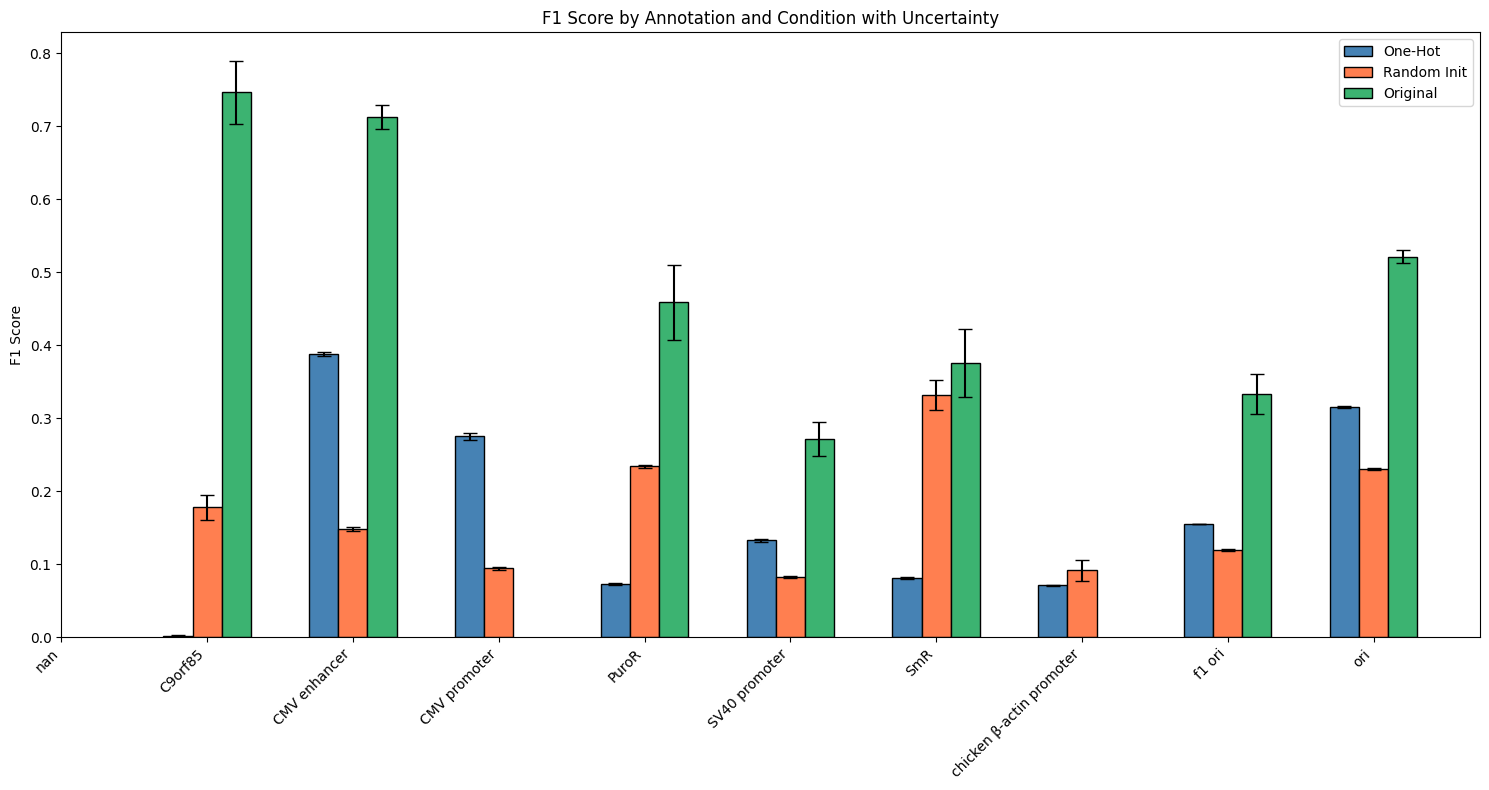

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



# Load the three summary files
# Adjust filenames to match your saved files
onehot_df = pd.read_csv('/content/drive/MyDrive/SAEs_for_Genomics/Probe Results L12 NT50/probe_results_NT50.L11mlp_control.onehottokens_summary_20250223_122731.csv', index_col=0)
print(onehot_df.head())
random_init_df = pd.read_csv('/content/drive/MyDrive/SAEs_for_Genomics/Probe Results L12 NT50/probe_results_NT50.RANDOMinit.L12mlp_summary_20250223_135819.csv', index_col=0)
print(random_init_df.head())
original_df = pd.read_csv('/content/drive/MyDrive/SAEs_for_Genomics/Probe Results L12 NT50/probe_results_NT50.L12mlp_summary_20250221_202348.csv', index_col=0)
print(original_df.head())


# List of dataframes and their labels
dfs = [onehot_df, random_init_df, original_df]
labels = ['One-Hot', 'Random Init', 'Original']
colors = ['#4682B4', '#FF7F50', '#3CB371']

# Ensure consistent indexing and clean data
for i, df in enumerate(dfs):
    # Drop unwanted rows and convert to numeric
    df.drop(index=['NaN', 'annotation'], inplace=True, errors='ignore')
    df['f1'] = pd.to_numeric(df['f1'], errors='coerce')
    df['f1_std'] = pd.to_numeric(df['f1.1'], errors='coerce')  # Get standard deviation
    # Reindex to include all annotations consistently
    dfs[i] = df.reindex(onehot_df.index)

# Get the list of annotations
annotations = onehot_df.index.tolist()
num_annotations = len(annotations)
bar_width = 0.2
x = np.arange(num_annotations)

# Set up the figure
plt.figure(figsize=(15, 8))

# Plot each condition with error bars
for i, (df, label, color) in enumerate(zip(dfs, labels, colors)):
    plt.bar(
        x + i * bar_width,
        df['f1'],
        yerr=df['f1_std'],  # Add error bars using std
        width=bar_width,
        label=label,
        color=color,
        capsize=5,  # Add caps to error bars
        edgecolor='black'
    )

# Labeling
plt.xticks(x + bar_width, annotations, rotation=45, ha='right')
plt.ylabel('F1 Score')
plt.title('F1 Score by Annotation and Condition with Uncertainty')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


# Comparing probe weights to SAE weights

If a linear probe learns to detect annotation A and we have an SAE latent who does too, we would expect the linear probe weights to align with the decoder row of the SAE latent. Thats because TODO

## Set-up & Load SAE

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

cfg = {
    "seed": 49,
    "batch_size": 4096*6,
    "buffer_mult": 384,
    "lr": 5e-5,
    #"num_tokens": tokenizer_nt.vocab_size,
    "d_model": 512,
    "l1_coeff": 1e-1,
    "beta1": 0.9,
    "beta2": 0.999,
    "dict_mult": 8, # hidden_d = d_model * dict_mult
    "seq_len": 512,
    "d_mlp": 512,
    "enc_dtype":"fp32",
    "remove_rare_dir": False,
    "total_training_steps": 10000,
    "lr_warm_up_steps": 1000,
    "device": "cuda"
}

cfg["model_batch_size"] = 64
cfg["buffer_size"] = cfg["batch_size"] * cfg["buffer_mult"]
cfg["buffer_batches"] = cfg["buffer_size"] // cfg["seq_len"]

DTYPES = {"fp32": torch.float32, "fp16": torch.float16, "bf16": torch.bfloat16}

class AutoEncoder(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # HP-choices
        d_hidden = cfg["d_mlp"] * cfg["dict_mult"]
        d_mlp = cfg["d_mlp"]
        self.l0_coeff = cfg.get("l0_coeff", 5)
        self.threshold = cfg.get("activation_threshold", 0.3)
        # Temperature for sigmoid approximation
        self.temperature = cfg.get("temperature", 1.0)
        dtype = DTYPES[cfg["enc_dtype"]]
        torch.manual_seed(cfg["seed"])

        self.W_enc = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_mlp, d_hidden, dtype=dtype)))
        self.W_dec = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_hidden, d_mlp, dtype=dtype)))
        self.b_enc = nn.Parameter(torch.zeros(d_hidden, dtype=dtype))
        self.b_dec = nn.Parameter(torch.zeros(d_mlp, dtype=dtype))
        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)

        self.d_hidden = d_hidden
        self.to("cuda") if torch.cuda.is_available() else self.to("cpu")

    def get_continuous_l0(self, x):
        """
        Compute continuous relaxation of L0 norm using sigmoid
        This provides useful gradients unlike the discrete L0
        """
        # Shifted sigmoid to approximate step function
        return torch.sigmoid((x.abs() - self.threshold) / self.temperature)

    def forward(self, x):
        # encoding and decoding of input vec
        x_cent = x - self.b_dec
        pre_acts = x_cent @ self.W_enc + self.b_enc
        acts = F.relu(pre_acts)

        # Compute continuous L0 approximation before thresholding
        l0_proxy = self.get_continuous_l0(acts)

        # Apply hard threshold for forward pass --- This is actually jumprelu (I think!)
        acts_sparse = (acts.abs() > self.threshold).float() * acts
        x_reconstruct = acts_sparse @ self.W_dec + self.b_dec

        # L2 Loss (Reconstruction Loss)
        l2_loss = F.mse_loss(x_reconstruct.float(), x.float(), reduction='none')
        l2_loss = l2_loss.sum(-1)
        l2_loss = l2_loss.mean()

        # Normalized MSE for reporting
        nmse = torch.norm(x - x_reconstruct, p=2) / torch.norm(x, p=2)

        # Continuous L0 loss (using sigmoid approximation)
        l0_loss = l0_proxy.sum(dim=1).mean()

        # Total Loss: reconstruction + sparsity
        loss = l2_loss + self.l0_coeff * l0_loss

        # For monitoring: true L0 count (not used in optimization)
        true_l0 = (acts_sparse.float().abs() > 0).float().sum(dim=1).mean()

        # For monitoring: L1 loss
        l1_loss = acts_sparse.float().abs().sum(-1).mean()

        return loss, x_reconstruct, acts_sparse, l2_loss, nmse, l1_loss, true_l0

    @torch.no_grad()
    def remove_parallel_component_of_grads(self):
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj


## Load already-trained SAE

In [14]:
random_weights_path = "/content/drive/MyDrive/SAEs_for_Genomics/sae_weights/main_sae/nt50m_sae_+40mtokens.pt"
state_dict = torch.load(random_weights_path)
sae_model = AutoEncoder(cfg)
sae_model.load_state_dict(state_dict)


<ipython-input-14-618c1a72582d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(random_weights_path)


<All keys matched successfully>

### Test: which decoder rows are most simialr

In [ ]:
import torch
import tqdm

# Move decoder weights to GPU
sae_decoder_weights = sae_model.W_dec.cuda()

# Normalize decoder weights to get unit vectors for cosine similarity
norms = torch.norm(sae_decoder_weights, dim=1, keepdim=True)
normalized_weights = sae_decoder_weights / norms

# Compute cosine similarity matrix using matrix multiplication
cosine_sim_matrix = torch.mm(normalized_weights, normalized_weights.t())

# To avoid self-similarity, set the diagonal to -1
cosine_sim_matrix.fill_diagonal_(-1)

# Get indices of pairs with similarity > 0.3
similar_pairs = torch.nonzero(cosine_sim_matrix > 0.4, as_tuple=True)

pbar = tqdm.tqdm(total=len(similar_pairs[0]))

for i, j in zip(similar_pairs[0].cpu().numpy(), similar_pairs[1].cpu().numpy()):
    pbar.update(1)
    print(f"Similarity between rows {i} and {j}: {cosine_sim_matrix[i, j].item()}")
    print()


  0%|          | 0/12 [00:00<?, ?it/s]

Similarity between rows 464 and 1671: 0.43906593322753906

Similarity between rows 631 and 1077: 0.4564729630947113

Similarity between rows 1077 and 631: 0.4564729630947113

Similarity between rows 1077 and 3300: 0.4030836522579193

Similarity between rows 1151 and 1377: 0.45218533277511597

Similarity between rows 1377 and 1151: 0.45218533277511597

Similarity between rows 1515 and 3596: 0.4461353123188019

Similarity between rows 1671 and 464: 0.43906593322753906

Similarity between rows 2361 and 3479: 0.4057186543941498

Similarity between rows 3300 and 1077: 0.4030836522579193

Similarity between rows 3479 and 2361: 0.4057186543941498

Similarity between rows 3596 and 1515: 0.4461353123188019



### Test: use decoder rows as linear probes

In [ ]:
# get decoder column 946
sae_decoder_weights = sae_model.W_dec.cpu().detach().numpy()
sae_encoder_weights = sae_model.W_enc.cpu().detach().numpy()
print(sae_encoder_weights.shape)
print(sae_decoder_weights.shape)
sae_decoder_weights[946,:].shape

(512, 4096)
(4096, 512)


(512,)

In [ ]:

# set weights and bias of model
model.weight.data = torch.from_numpy(sae_decoder_weights[946,:].reshape(1, -1))
model.bias.data = torch.tensor(-5.0)
model.cuda()


# For each annotation experiment:
annotation = 'PuroR' ## the annotation that the SAE latent is monosemantic for
print("Processing annotation:", annotation)

result = process_annotation(
    df=token_df_1k_s0,
    xs=xs,
    annotation=annotation,
    target_value='TATA'
)
x_tensor = result['features']
y_tensor = result['labels']


address_imbalance = True
if address_imbalance:
    # Calculate class weights based on inverse frequency
    n_samples = len(y_tensor)
    n_positive = y_tensor.sum()
    pos_weight = (n_samples - n_positive) / n_positive

results = trainer.evaluate(x_tensor, y_tensor)


PuroR
Baserate accuracy: 0.9949558933933934
Validation Accuracy: 0.9950, Best Precision: 0.5172, Best Recall: 0.0581, Best F1: 0.1045


## Analyse linear probe weights ~ SAE decoder weights

In [19]:
linear_probe_weights = model.weight.cpu().detach().numpy()
sae_encoder_weights = sae_model.W_enc.cpu().detach().numpy()
sae_decoder_weights = sae_model.W_dec.cpu().detach().numpy()

# Dot products
dot_products_enc = linear_probe_weights @ sae_encoder_weights
# now dot products with decoder weights
dot_products_decoder = linear_probe_weights @ sae_decoder_weights.T

# Compute L2 norms
linear_probe_norms = np.linalg.norm(linear_probe_weights, axis=1, keepdims=True)  # Keep dims for broadcasting
encoder_norms = np.linalg.norm(sae_encoder_weights, axis=0, keepdims=True)  # Keep dims for broadcasting
decoder_norms = np.linalg.norm(sae_decoder_weights.T, axis=0, keepdims=True)  # Keep dims for broadcasting

# Cosine similarities
cosine_sims_enc = dot_products_enc / (linear_probe_norms @ encoder_norms)
cosine_sims_decoder = dot_products_decoder / (linear_probe_norms @ decoder_norms)


print("\nMax cosine similarity:", cosine_sims_enc.max())
print("Min cosine similarity:", cosine_sims_enc.min())
print("Mean absolute cosine similarity:", np.abs(cosine_sims_enc).mean())

print("\nMax cosine similarity:", cosine_sims_decoder.max())
print("Min cosine similarity:", cosine_sims_decoder.min())
print("Mean absolute cosine similarity:", np.abs(cosine_sims_decoder).mean())


Max cosine similarity: 0.47252184
Min cosine similarity: -0.25448462
Mean absolute cosine similarity: 0.036452737

Max cosine similarity: 0.43885103
Min cosine similarity: -0.25140515
Mean absolute cosine similarity: 0.03604088


In [20]:
import plotly.express as px

# Create labels for x-axis
num_sae_units = dot_products_enc.shape[1]
x_labels = [f'SAE Unit {i}' for i in range(num_sae_units)]

# 1. Histogram
fig_hist = px.histogram(
    x=np.repeat(x_labels, dot_products_decoder.shape[0]),
    y=cosine_sims_decoder.flatten(),
    title='Distribution of Cosine Similarities for each SAE Unit',
    labels={'x': 'SAE Decoder Units', 'y': 'Cosine Similarity'},
    nbins=50
)

fig_hist.update_layout(
    showlegend=False,
    width=1000,
    height=600
)


fig_hist.show()


In [21]:
# get max cosine_sim_enc value

max_cosine_sim_enc = cosine_sims_enc.max()
max_cosine_sim_decoder = cosine_sims_decoder.max()

# get index (sea latent) for each
max_cosine_sim_enc_idx = np.argmax(cosine_sims_enc)
max_cosine_sim_decoder_idx = np.argmax(cosine_sims_decoder)

print("Max cosine similarity:", max_cosine_sim_enc)
print("Max cosine similarity decoder:", max_cosine_sim_decoder)
print("Max cosine similarity index:", max_cosine_sim_enc_idx)
print("Max cosine similarity index decoder:", max_cosine_sim_decoder_idx)

Max cosine similarity: 0.47252184
Max cosine similarity decoder: 0.43885103
Max cosine similarity index: 2222
Max cosine similarity index decoder: 2222
